## Problem Statement

A retail store has been collecting weekly sales quantity of a product and using regular time series models like ARIMA to estimate future weeks sales. Observed that the accuracy of the model is not good for all weeks then they collected other informations like variations in the price and wheather data. 

They want to understand whether the collected information is helpful to forecast future sales or not and is it sufficient to estimate accurate forecast quantity.

#### The objective is to implement ARIMA model to forecast the quantity and include the additonal information provided and implement ARIMAX model to study the influence of those variables in forecasting the quantity of coming weeks.

In [54]:
library(dplyr)
library(TTR)
library(forecast)
library(DMwR)
library(tseries)

In [55]:
options(repr.plot.width = 20, repr.plot.height = 10)

#### Read the Product weekly sales data

In [56]:
product_data = read.csv("productWeeklyData.csv")

#### The data has the following attributes:

- Year                        : Year in YYYY format.
- Week_Of_The_Year            : Week of the year in which sale has happend. The value ranges from 0 to 52.
- quantityPerWeek (Target)    : Quantity of an item sold in the week. 
- NoOfWeeklyPromotion         : Number of promotions done in the week.
- AverageWeeklyPriceChange    : Mean value of weekly prices change. 
- weeklyPromotion             : Whether sales had a promotion in the week or not ("N" & "Y").

In [57]:
dim(product_data)

[1] 174   6

In [58]:
head(product_data)

,Year,Week_Of_The_Year,quantityPerWeek,NoOfWeeklyPromotion,AverageWeeklyPriceChange,weeklyPromotion
,<int>,<int>,<int>,<int>,<dbl>,<chr>
1,2013,34,33,0,0.00000000,N
2,2013,35,142,0,0.00000000,N
3,2013,36,591,7,0.07142857,Y
4,2013,37,460,7,0.14285714,Y
5,2013,38,127,7,-0.01428571,Y
6,2013,39,80,7,-0.10000000,Y


In [59]:
summary(product_data)

      Year      Week_Of_The_Year quantityPerWeek  NoOfWeeklyPromotion
 Min.   :2013   Min.   : 0.00    Min.   :  24.0   Min.   :0.000      
 1st Qu.:2014   1st Qu.:14.00    1st Qu.: 111.0   1st Qu.:4.250      
 Median :2015   Median :28.50    Median : 161.0   Median :7.000      
 Mean   :2015   Mean   :27.29    Mean   : 303.6   Mean   :5.368      
 3rd Qu.:2016   3rd Qu.:40.75    3rd Qu.: 385.8   3rd Qu.:7.000      
 Max.   :2016   Max.   :52.00    Max.   :2216.0   Max.   :7.000      
 AverageWeeklyPriceChange weeklyPromotion   
 Min.   :-0.80000         Length:174        
 1st Qu.:-0.20000         Class :character  
 Median :-0.10000         Mode  :character  
 Mean   :-0.09229                           
 3rd Qu.: 0.00000                           
 Max.   : 0.20000                           

#### Sort the data w.r.t Year and Week_Of_The_Year

In [60]:
product_data = product_data[ order(product_data$Year, product_data$Week_Of_The_Year),] 

head(product_data)

,Year,Week_Of_The_Year,quantityPerWeek,NoOfWeeklyPromotion,AverageWeeklyPriceChange,weeklyPromotion
,<int>,<int>,<int>,<int>,<dbl>,<chr>
1,2013,34,33,0,0.00000000,N
2,2013,35,142,0,0.00000000,N
3,2013,36,591,7,0.07142857,Y
4,2013,37,460,7,0.14285714,Y
5,2013,38,127,7,-0.01428571,Y
6,2013,39,80,7,-0.10000000,Y


#### Missing Values

In [61]:
sum(is.na(product_data))

[1] 0

### Read weather data

In [62]:
weather_data = read.csv("WeatherData.csv")
head(weather_data)

,Date,Mean.TemperatureC,fog,rain,snow,hail,thunder,tornado
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,2014-01-01,12,0,0,0,0,0,0
2,2014-01-02,14,0,0,0,0,0,0
3,2014-01-03,13,0,0,0,0,0,0
4,2014-01-04,12,0,0,0,0,0,0
5,2014-01-05,12,0,0,0,0,0,0
6,2014-01-06,13,0,0,0,0,0,0


#### Missing Values

In [63]:
sum(is.na(weather_data))

[1] 0

### Convert to date format and extract year and week information

In [64]:
weather_data$Date             = as.Date(weather_data$Date, format="%Y-%m-%d")
weather_data$Year             = format(weather_data$Date, "%Y")
weather_data$Week_Of_The_Year = format(weather_data$Date, "%W")

head(weather_data)

,Date,Mean.TemperatureC,fog,rain,snow,hail,thunder,tornado,Year,Week_Of_The_Year
,<date>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
1,2014-01-01,12,0,0,0,0,0,0,2014,00
2,2014-01-02,14,0,0,0,0,0,0,2014,00
3,2014-01-03,13,0,0,0,0,0,0,2014,00
4,2014-01-04,12,0,0,0,0,0,0,2014,00
5,2014-01-05,12,0,0,0,0,0,0,2014,00
6,2014-01-06,13,0,0,0,0,0,0,2014,01


### Bin the mean temp for a day to High/Meduim/Low temp

In [65]:
library("infotheo")

weather_data$temperaturebins = discretize(weather_data$Mean.TemperatureC, disc="equalwidth", nbins = 3)$X

In [66]:
head(weather_data)

,Date,Mean.TemperatureC,fog,rain,snow,hail,thunder,tornado,Year,Week_Of_The_Year,temperaturebins
,<date>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>
1,2014-01-01,12,0,0,0,0,0,0,2014,00,1
2,2014-01-02,14,0,0,0,0,0,0,2014,00,2
3,2014-01-03,13,0,0,0,0,0,0,2014,00,2
4,2014-01-04,12,0,0,0,0,0,0,2014,00,1
5,2014-01-05,12,0,0,0,0,0,0,2014,00,1
6,2014-01-06,13,0,0,0,0,0,0,2014,01,2


#### Function to find the mode values

In [67]:
getMode = function(v) { return(as.numeric(names(sort(table(v), decreasing = T))[1])) }

# Demo
getMode(c(2, 1, 2, 3, 1, 2, 1))

[1] 1

### Deriving the features from temeprature data

As the product data is weekly, we have to convert Weather data to weekly.

In [68]:
library("dplyr")

weather_temp = weather_data %>% group_by(Year, Week_Of_The_Year) %>% 
                                    summarise("meanTemperatureOfWeek" = mean(Mean.TemperatureC),
                                                "CountOfHighTempBins"   = sum(temperaturebins == 3),
                                                "CountOfMedTempBins"    = sum(temperaturebins == 2),
                                                "CountOfLowTempBins"    = sum(temperaturebins == 1),
                                                "temperaturebins"       = getMode(temperaturebins)) %>% data.frame()


weather_temp$temperaturebins  = as.factor(weather_temp$temperaturebins)
weather_temp$Year             = as.integer(weather_temp$Year)
weather_temp$Week_Of_The_Year = as.integer(weather_temp$Week_Of_The_Year)

summary(weather_temp)

`summarise()` regrouping output by 'Year' (override with `.groups` argument)



      Year      Week_Of_The_Year meanTemperatureOfWeek CountOfHighTempBins
 Min.   :2014   Min.   : 0.00    Min.   : 4.333        Min.   :0.000      
 1st Qu.:2014   1st Qu.:10.75    1st Qu.:12.686        1st Qu.:0.000      
 Median :2015   Median :23.00    Median :16.714        Median :0.000      
 Mean   :2015   Mean   :24.26    Mean   :17.453        Mean   :1.699      
 3rd Qu.:2016   3rd Qu.:38.00    3rd Qu.:22.750        3rd Qu.:4.000      
 Max.   :2017   Max.   :52.00    Max.   :28.857        Max.   :7.000      
 CountOfMedTempBins CountOfLowTempBins temperaturebins
 Min.   :0.000      Min.   :0.000      1:41           
 1st Qu.:1.000      1st Qu.:0.000      2:89           
 Median :4.000      Median :0.000      3:46           
 Mean   :3.699      Mean   :1.472                     
 3rd Qu.:7.000      3rd Qu.:3.000                     
 Max.   :7.000      Max.   :7.000                     

### Join the dataframes

In [69]:
dim(product_data)
dim(weather_temp)

head(product_data, 3)
head(weather_temp, 3)

[1] 174   6

[1] 176   7

,Year,Week_Of_The_Year,quantityPerWeek,NoOfWeeklyPromotion,AverageWeeklyPriceChange,weeklyPromotion
,<int>,<int>,<int>,<int>,<dbl>,<chr>
1,2013,34,33,0,0.00000000,N
2,2013,35,142,0,0.00000000,N
3,2013,36,591,7,0.07142857,Y


,Year,Week_Of_The_Year,meanTemperatureOfWeek,CountOfHighTempBins,CountOfMedTempBins,CountOfLowTempBins,temperaturebins
,<int>,<int>,<dbl>,<int>,<int>,<int>,<fct>
1,2014,0,12.60000,0,2,3,1
2,2014,1,10.85714,0,2,5,1
3,2014,2,15.14286,0,7,0,2


In [70]:
data = merge(x = product_data, y = weather_temp, by = c("Year","Week_Of_The_Year"), all = FALSE)

### Sort the data based on year and week number.

In [17]:
data <- data[order(data$Year, data$Week_Of_The_Year),] 

dim(data)
head(data, 3)

rm(product_data, weather_temp, getMode)

[1] 155  11

,Year,Week_Of_The_Year,quantityPerWeek,NoOfWeeklyPromotion,AverageWeeklyPriceChange,weeklyPromotion,meanTemperatureOfWeek,CountOfHighTempBins,CountOfMedTempBins,CountOfLowTempBins,temperaturebins
,<int>,<int>,<int>,<int>,<dbl>,<chr>,<dbl>,<int>,<int>,<int>,<fct>
1,2014,0,123,4,-0.5,Y,12.60000,0,2,3,1
2,2014,1,139,7,-0.5,Y,10.85714,0,2,5,1
13,2014,2,100,7,-0.5,Y,15.14286,0,7,0,2


### ARIMAX accepts only numerics attribute. So, convert categorial attributes to numeric using dummification

In [78]:
library(caret)

dummyModel  = dummyVars( ~weeklyPromotion+temperaturebins, data)
dataCat2Num = predict(dummyModel, data)

head(dataCat2Num)

,weeklyPromotionY,temperaturebins.2,temperaturebins.3
1,1,0,0
2,1,0,0
3,1,1,0
4,0,1,0
5,0,1,0
6,0,0,0


### Combine the dummified data

In [19]:
dataNum = data[ , setdiff(names(data), c("weeklyPromotion", "temperaturebins"))]

data = cbind(dataNum, dataCat2Num)

head(data, 3)

rm(dataCat2Num, dataNum, dummyModel)

,Year,Week_Of_The_Year,quantityPerWeek,NoOfWeeklyPromotion,AverageWeeklyPriceChange,meanTemperatureOfWeek,CountOfHighTempBins,CountOfMedTempBins,CountOfLowTempBins,weeklyPromotionN,weeklyPromotionY,temperaturebins.1,temperaturebins.2,temperaturebins.3
,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2014,0,123,4,-0.5,12.60000,0,2,3,0,1,1,0,0
2,2014,1,139,7,-0.5,10.85714,0,2,5,0,1,1,0,0
13,2014,2,100,7,-0.5,15.14286,0,7,0,0,1,0,1,0


### Split the data into Train and Validation

In [20]:
noOfWeekstoForcast = 4

trainRowID = 1:(nrow(data) - noOfWeekstoForcast)
trainData = data[trainRowID,]
valData = data[-trainRowID,]

nrow(trainData)
nrow(valData)
rm(trainRowID)

[1] 151

[1] 4

In [21]:
trainTS = ts(trainData$quantityPerWeek, frequency = 53, start = c(2014, 1))
valTS = ts(valData$quantityPerWeek, frequency = 53, start = c(2016, 46))

### Build Arima Model

In [22]:
library(forecast)

arima_Model = auto.arima(trainTS)

summary(arima_Model)

Series: trainTS 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
         ar1      mean
      0.4228  289.4778
s.e.  0.0737   42.5071

sigma^2 estimated as 93015:  log likelihood=-1077.11
AIC=2160.22   AICc=2160.38   BIC=2169.27

Training set error measures:
                    ME     RMSE      MAE       MPE    MAPE      MASE
Training set 0.5707082 302.9576 184.9218 -85.84398 106.897 0.8069435
                    ACF1
Training set 0.009930363


         Point Forecast      Lo 80    Hi 80     Lo 95     Hi 95
2016.849       439.7841   48.93126 830.6370 -157.9737 1037.5420
2016.868       353.0237  -71.32437 777.3718 -295.9607 1002.0081
2016.887       316.3435 -113.71681 746.4038 -341.3770  974.0639
2016.906       300.8360 -130.23736 731.9093 -358.4338  960.1057

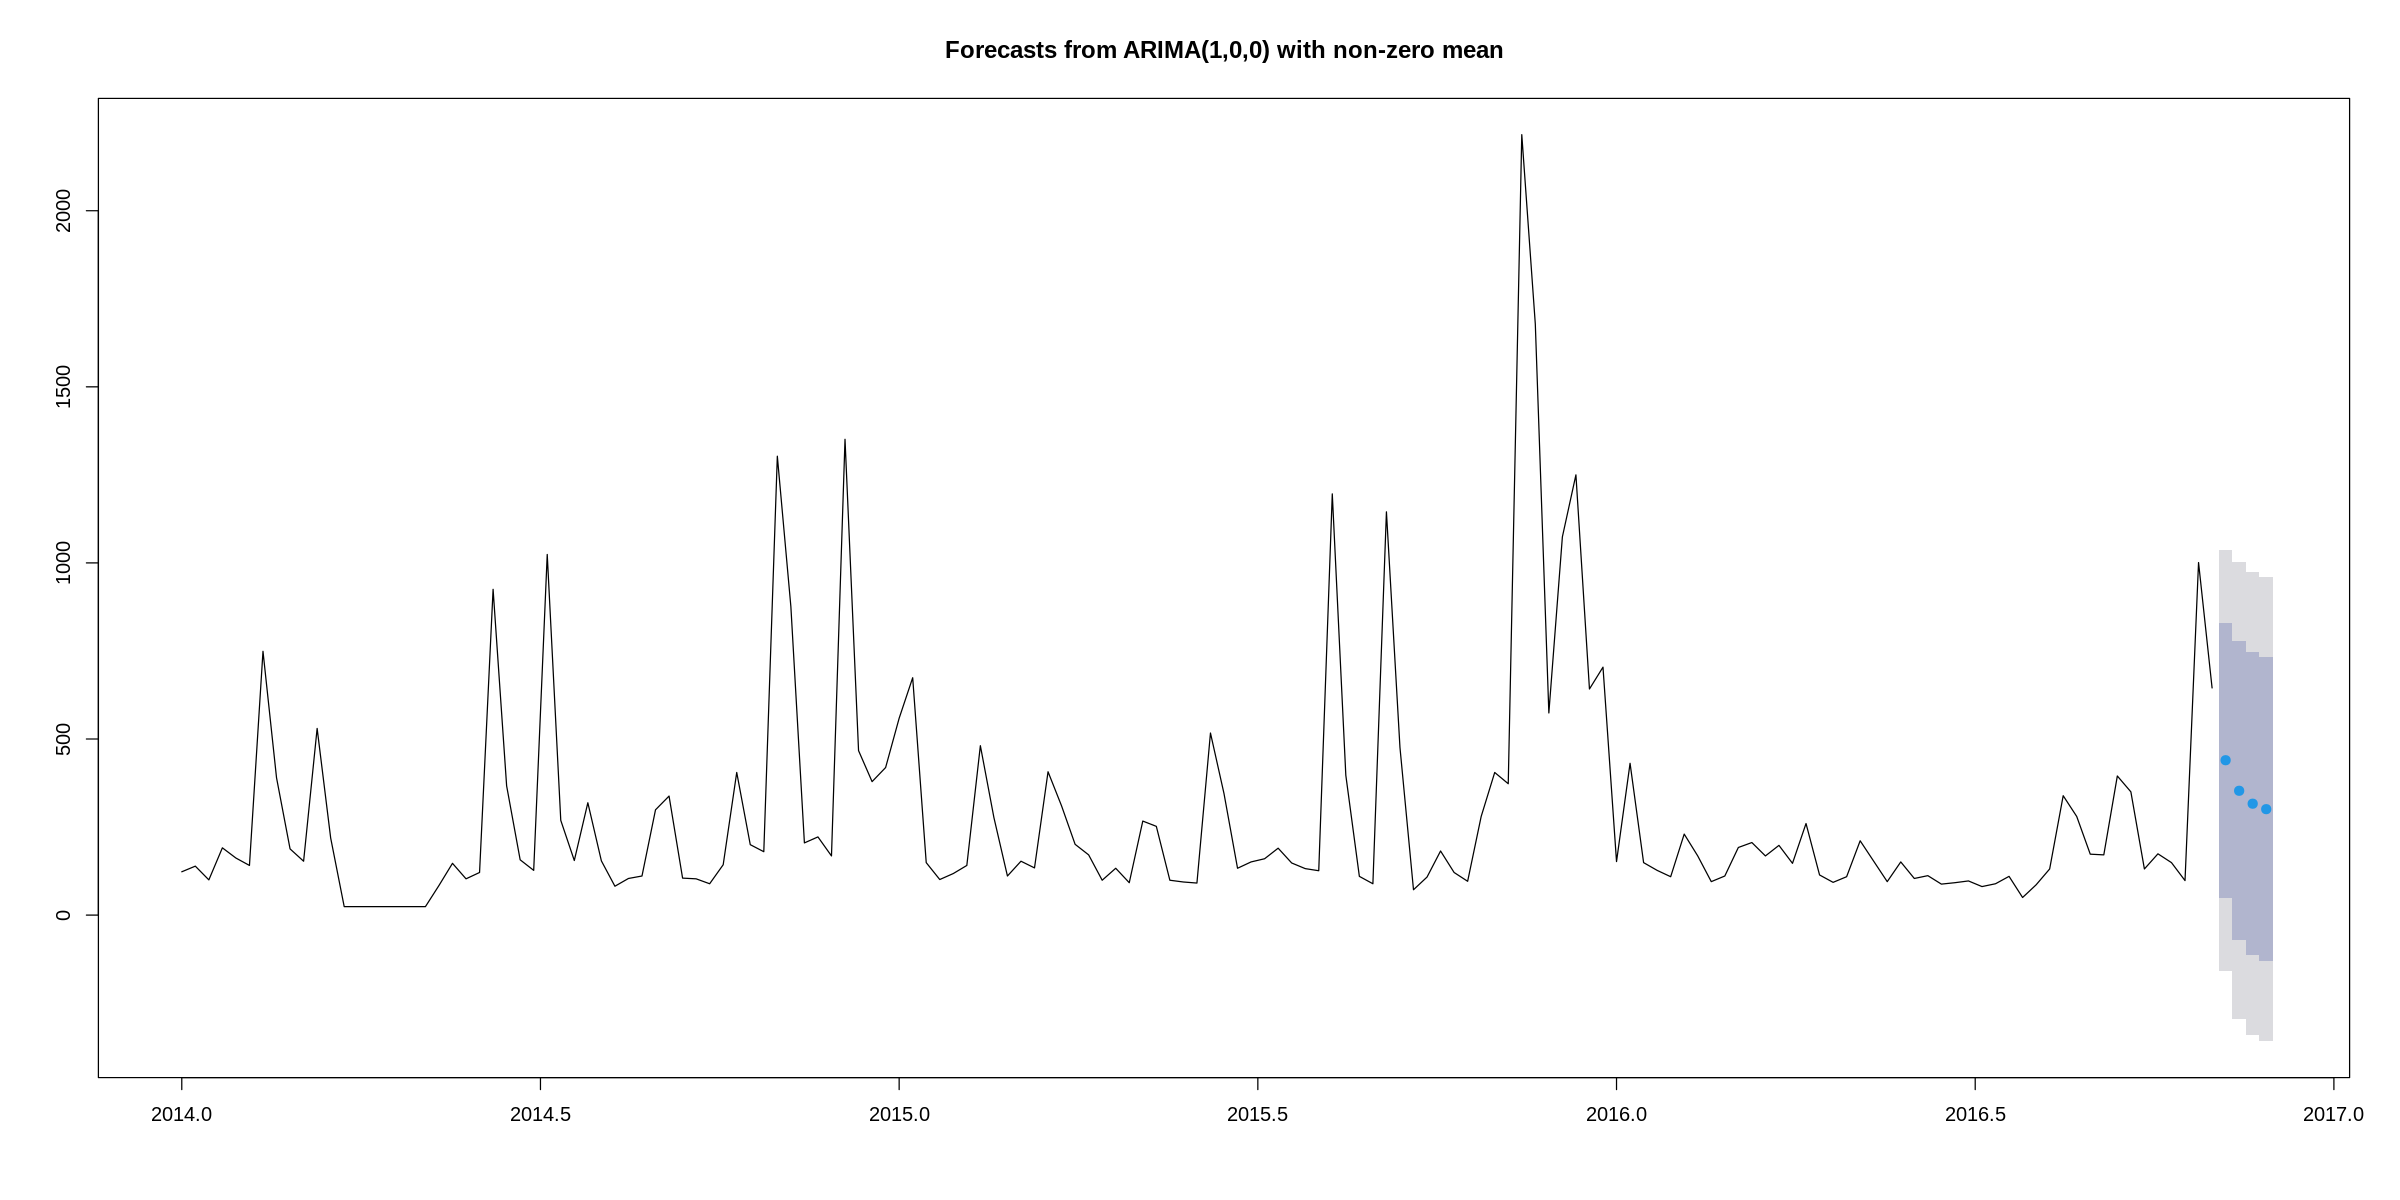

In [23]:
val_Arima_Pred = forecast(arima_Model, h = noOfWeekstoForcast)
val_Arima_Pred

plot(val_Arima_Pred)

In [24]:
regr.eval(trainTS, arima_Model$fitted)
regr.eval(valData$quantityPerWeek, data.frame(val_Arima_Pred)$Point.Forecast)

mae         mse        rmse        mape 
  184.92180 91783.31341   302.95761     1.06897

mae          mse         rmse         mape 
3.288132e+02 1.536941e+05 3.920384e+02 6.445277e-01

### Build ArimaX Model

In [25]:
str(trainData)

'data.frame':	151 obs. of  14 variables:
 $ Year                    : int  2014 2014 2014 2014 2014 2014 2014 2014 2014 2014 ...
 $ Week_Of_The_Year        : int  0 1 2 3 4 5 6 7 8 9 ...
 $ quantityPerWeek         : int  123 139 100 191 162 141 749 390 188 153 ...
 $ NoOfWeeklyPromotion     : int  4 7 7 7 7 7 7 7 7 7 ...
 $ AverageWeeklyPriceChange: num  -0.5 -0.5 -0.5 -0.0614 -0.06 ...
 $ meanTemperatureOfWeek   : num  12.6 10.9 15.1 14.4 11.1 ...
 $ CountOfHighTempBins     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ CountOfMedTempBins      : int  2 2 7 6 2 0 7 6 5 7 ...
 $ CountOfLowTempBins      : int  3 5 0 1 5 7 0 1 2 0 ...
 $ weeklyPromotionN        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ weeklyPromotionY        : num  1 1 1 1 1 1 1 1 1 1 ...
 $ temperaturebins.1       : num  1 1 0 0 1 1 0 0 0 0 ...
 $ temperaturebins.2       : num  0 0 1 1 0 0 1 1 1 1 ...
 $ temperaturebins.3       : num  0 0 0 0 0 0 0 0 0 0 ...


In [80]:
arimax_Model = auto.arima(trainTS, xreg = as.matrix( trainData[ , c(4, 5, 6, 11, 13, 14)]) )

summary(arimax_Model)

Series: trainTS 
Regression with ARIMA(0,0,5) errors 

Coefficients:
         ma1     ma2     ma3     ma4     ma5  weeklyPromotionY
      0.4439  0.1289  0.2226  0.3435  0.2114          198.1240
s.e.  0.0800  0.0921  0.0978  0.0907  0.0771           61.2923
      temperaturebins.2  temperaturebins.3
               140.5236           136.6854
s.e.            62.0781            86.4434

sigma^2 estimated as 83932:  log likelihood=-1066.49
AIC=2150.98   AICc=2152.26   BIC=2178.14

Training set error measures:
                   ME    RMSE      MAE       MPE     MAPE      MASE        ACF1
Training set 9.523634 281.932 169.4891 -52.04983 84.21427 0.7395996 0.003382878


         Point Forecast     Lo 80    Hi 80     Lo 95     Hi 95
2016.849       362.3269  -8.95255 733.6064 -205.4960  930.1499
2016.868       438.9071  32.69839 845.1157 -182.3355 1060.1496
2016.887       458.6968  49.68000 867.7136 -166.8404 1084.2340
2016.906       390.4909 -26.79158 807.7734 -247.6876 1028.6694

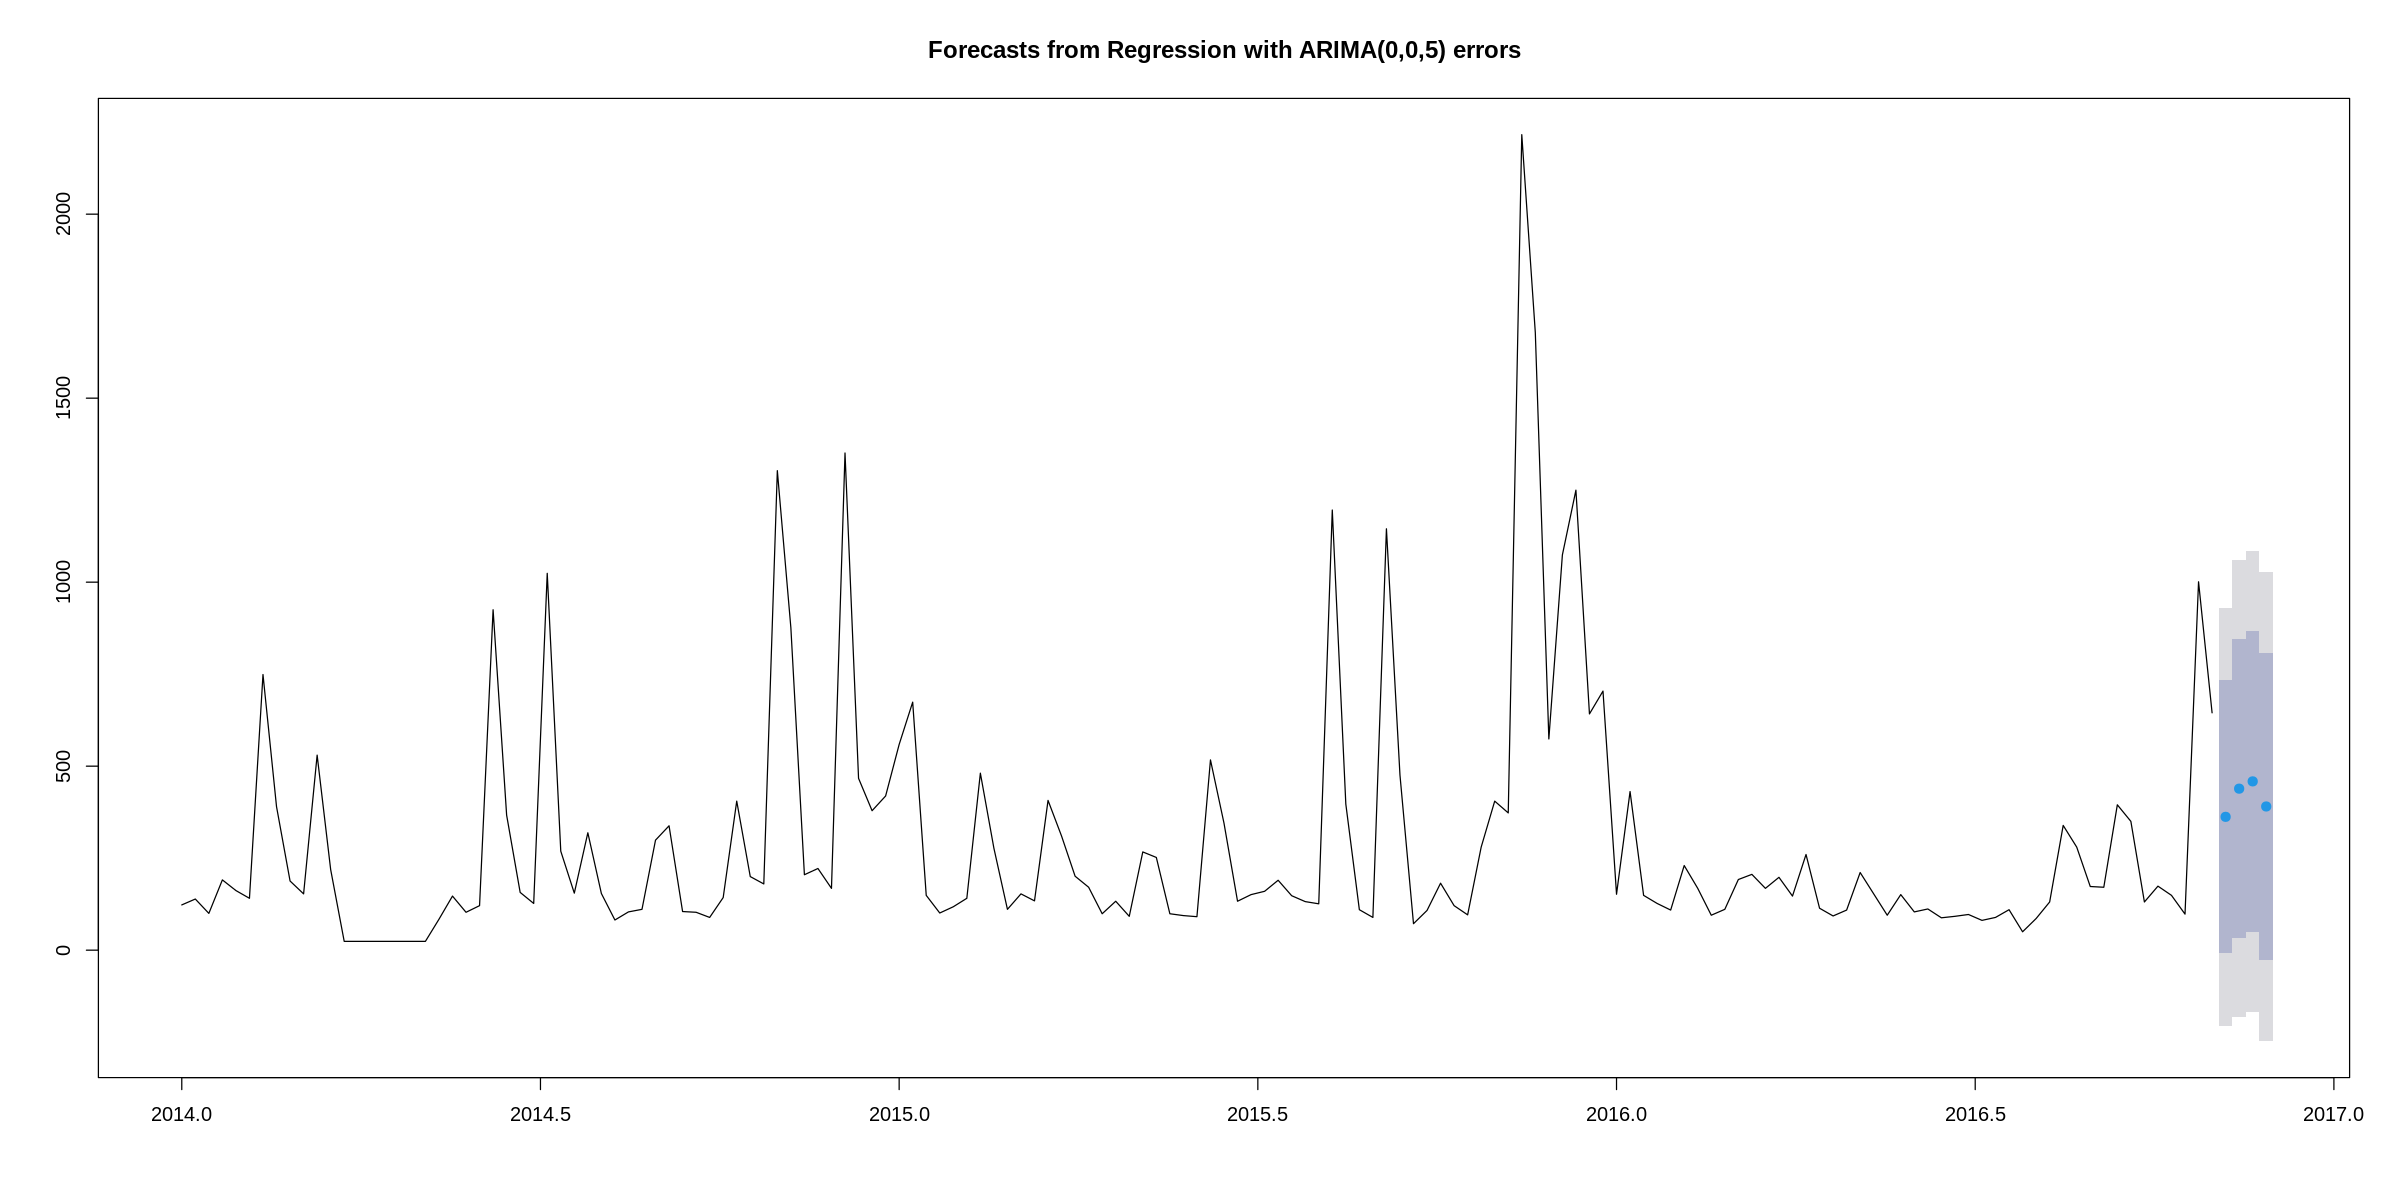

In [81]:
val_ARIMAX_Pred = forecast(arimax_Model, h = noOfWeekstoForcast, xreg = as.matrix(valData[ , c(4, 5, 6, 11, 13, 14)]))
val_ARIMAX_Pred
plot(val_ARIMAX_Pred)

In [82]:
regr.eval(trainData$quantityPerWeek, fitted(arimax_Model))
regr.eval(valData$quantityPerWeek, data.frame(val_ARIMAX_Pred)$Point.Forecast)

mae          mse         rmse         mape 
1.694891e+02 7.948566e+04 2.819320e+02 8.421427e-01

mae          mse         rmse         mape 
2.748035e+02 9.659044e+04 3.107900e+02 5.851187e-01